<h1>Hadware usado</h1>
Los siguientes modelos fueron corridos en maquinas virtuales de google (cuadernos de IA Platform)

In [1]:
!nvidia-smi

Sat Feb  8 19:41:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    71W / 149W |      0MiB / 11441MiB |    100%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

<h2>Librerias</h2>

Se usa libreria <code>datatime</code> para obtener la hora especifica, lo usamos para guardar los modelos periodicamente a medida que lo ibamos entrenando

In [2]:
import pandas as pd
import sys
import os
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import optimizers
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout, Flatten, Dense, Activation, Add
from tensorflow.python.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.python.keras import backend as K
import PIL

from tensorflow.python.keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import datetime


<h2>Hiperparametros</h2>

In [21]:
#K.image_data_format() CHANNELS_LAST
nb_train_samples = 7947 
nb_validation_samples = 300

train_dir = 'data/train'
dev_dir = 'data/dev'
test_dir = 'data/test'
epochs = 10
width, height = 306, 306
batch_size = 16
steps = nb_train_samples // batch_size
validation_steps = nb_validation_samples // batch_size
#Tamaño profundidad de filtros
filtersConv1 = 32
filtersConv2 = 32
filtersConv3 = 64

#Tamaño de los filtros
filter_size1 = (3,3)
filter_size2 = (3,3)
filter_size3 = (3,3)
#PoolSizes
pool_size1 = (2,2)
pool_size2 = (2,2)
pool_size3 = (2,2)

number_class = 3
learning_rate = 0.005
lr = learning_rate
#Limpiamos sesiones previas
K.clear_session()

filter_convs = [filtersConv1, filtersConv2, filtersConv3]
filter_sizes = [filter_size1, filter_size2, filter_size3]
pool_sizes   = [pool_size1, pool_size2, pool_size3]

 

<h2>Modelo</h2>

In [4]:
def model(input_shape, filter_convs, filter_sizes, pool_sizes):
    width, height = input_shape[0], input_shape[1] 
    if K.image_data_format() == 'channels_first':
        input_shape = (3, width, height)
    else:
        input_shape = (width, height, 3)

    network =Sequential()
    print(input_shape)
    #first layer
    network.add(Convolution2D( filter_convs[0],
                               filter_sizes[0], 
                               padding='same', 
                               input_shape = input_shape,
                               activation='relu'
                             ))
    network.add(MaxPooling2D(pool_size=pool_sizes[0]))
    
    #Second layer
    network.add(Convolution2D( filter_convs[1],
                               filter_sizes[1],  
                               activation='relu'
                             ))
    network.add(MaxPooling2D(pool_size=pool_sizes[1]))
    
    #third layer
    network.add(Convolution2D( filter_convs[2],
                               filter_sizes[2], 
                               activation='relu'
                             ))
    
    network.add(MaxPooling2D(pool_size=pool_sizes[2]))
    
    
    network.add(Flatten())
    network.add(Dense(64))
    network.add(Activation('relu'))
    network.add(Dropout(0.5))
    network.add(Dense(3))
    network.add(Activation('softmax'))



    
    return network

In [5]:
input_shape = (width, height)
cnn = model(input_shape, filter_convs, filter_sizes, pool_sizes )
#Primer modelo
#cnn.compile(loss='mean_squared_error', optimizer='Adam', metrics = ['accuracy'])
#CategoricalCrossentropy
cnn.compile(loss='categorical_crossentropy', optimizer='Adam', metrics = ['accuracy', 'mean_squared_error'])


(306, 306, 3)


<h2>Data</h2>

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.2,0.8],
    rotation_range=20,
)
    

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(width, height),
    batch_size=batch_size,
    class_mode='categorical')
    
validation_generator = test_datagen.flow_from_directory(
    dev_dir,
    target_size=(width, height),
    batch_size=batch_size,
    class_mode='categorical')
    
 

Found 7629 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


<h2>Entrenando el modelo</h2>

In [7]:
history = cnn.fit_generator(
        train_generator,
        steps_per_epoch=steps,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        use_multiprocessing=True,
        workers = 4
    )


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 496 steps, validate for 18 steps
Epoch 1/10
496/496 [==============================] - 218s 440ms/step - loss: 0.9959 - accuracy: 0.5234 - mean_squared_error: 0.1976 - val_loss: 0.8808 - val_accuracy: 0.5694 - val_mean_squared_error: 0.1776
Epoch 2/10
496/496 [==============================] - 223s 449ms/step - loss: 0.9234 - accuracy: 0.5621 - mean_squared_error: 0.1818 - val_loss: 0.8945 - val_accuracy: 0.5208 - val_mean_squared_error: 0.1807
Epoch 3/10
496/496 [==============================] - 223s 449ms/step - loss: 0.8902 - accuracy: 0.5814 - mean_squared_error: 0.1750 - val_loss: 0.9327 - val_accuracy: 0.5139 - val_mean_squared_error: 0.1900
Epoch 4/10
496/496 [==============================] - 222s 448ms/step - loss: 0.8674 - accuracy: 0.5879 - mean_squared_error: 0.1703 - val_loss: 0.8375 - val_accuracy: 0.5486 - val_mean_squared_error: 0.1719

In [9]:
dir = 'modelo_final/'+ str(datetime.datetime.now()) + '/'
if os.path.exists(dir) == False:
    os.mkdir(dir)
    #os.path.exists(dir)
cnn.save(dir + 'modelo.h5')
cnn.save_weights(dir  +'weights.h')


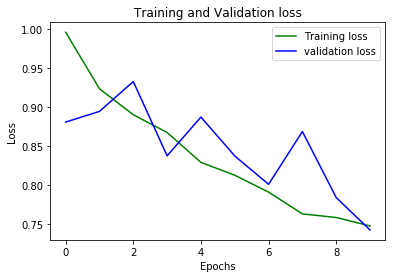

In [12]:
import matplotlib.pyplot as plt
loss_train = history.history['loss']
loss_val = history.history['val_loss']
img = plt.gcf()
plt.plot(range(0,epochs), loss_train, 'g', label='Training loss')
plt.plot(range(0,epochs), loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

img.savefig('final_plot/training_lost_first.png')

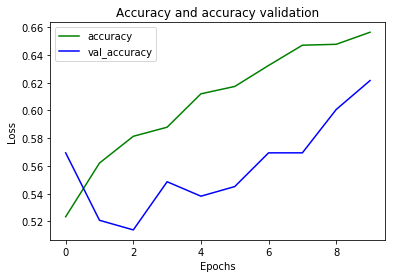

In [13]:
import matplotlib.pyplot as plt
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
img = plt.gcf()
plt.plot(range(0,epochs), loss_train, 'g', label='accuracy')
plt.plot(range(0,epochs), loss_val, 'b', label='val_accuracy')
plt.title('Accuracy and accuracy validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
img.savefig('final_plot/accuracy_fisrt.png')

<h2>Cargando modelo entrenado</h2>
Puesto que el modelo se entreno con mas epocas, se carga este ultimo y con el fin de visualizar los errores se entrena con una cantidad menor de datos

In [8]:
loaded_model= tf.keras.models.load_model('modelo2/modelo.h5')
nb_train_samples = 1000 
nb_validation_samples = 300


epochs = 10
width, height = 306, 306
batch_size = 16
steps = nb_train_samples // batch_size
validation_steps = nb_validation_samples // batch_size

In [9]:
history = loaded_model.fit_generator(
        train_generator,
        steps_per_epoch=steps,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=nb_validation_samples // batch_size,
        use_multiprocessing=True,
        workers = 8
    )

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 62 steps, validate for 18 steps
Epoch 1/10
62/62 [==============================] - 33s 533ms/step - loss: 0.5369 - accuracy: 0.7651 - val_loss: 0.4885 - val_accuracy: 0.7674
Epoch 2/10
62/62 [==============================] - 34s 548ms/step - loss: 0.5638 - accuracy: 0.7429 - val_loss: 0.5818 - val_accuracy: 0.7257
Epoch 3/10
62/62 [==============================] - 35s 557ms/step - loss: 0.5268 - accuracy: 0.7671 - val_loss: 0.5418 - val_accuracy: 0.7569
Epoch 4/10
62/62 [==============================] - 36s 580ms/step - loss: 0.5566 - accuracy: 0.7470 - val_loss: 0.5868 - val_accuracy: 0.7257
Epoch 5/10
62/62 [==============================] - 34s 543ms/step - loss: 0.5257 - accuracy: 0.7877 - val_loss: 0.5124 - val_accuracy: 0.7639
Epoch 6/10
62/62 [==============================] - 35s 572ms/step - loss: 0.5555 - accuracy: 0.7490 - val_loss: 0.53

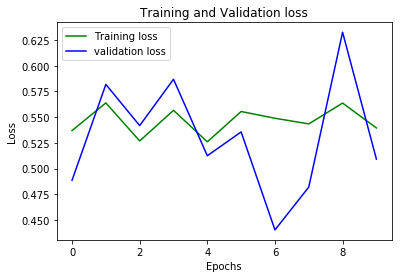

In [10]:
import matplotlib.pyplot as plt
loss_train = history.history['loss']
loss_val = history.history['val_loss']
img = plt.gcf()
plt.plot(range(0,epochs), loss_train, 'g', label='Training loss')
plt.plot(range(0,epochs), loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

img.savefig('final_plot/training_lost_last.png')

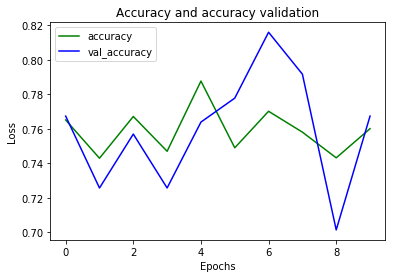

In [11]:
import matplotlib.pyplot as plt
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
img = plt.gcf()
plt.plot(range(0,epochs), loss_train, 'g', label='accuracy')
plt.plot(range(0,epochs), loss_val, 'b', label='val_accuracy')
plt.title('Accuracy and accuracy validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
img.savefig('final_plot/accuracy_last.png')

<h2>Test</h2>
Probamos el modelo con un conjunto de etiquetas propio

In [34]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(306, 306),
        class_mode='categorical',
)

Found 310 images belonging to 3 classes.


In [35]:
pred = loaded_model.evaluate(test_generator)

  ...
    to  
  ['...']
10/10 [==============================] - 1s 136ms/step - loss: 0.5789 - accuracy: 0.7419


<h2>Envio</h2>
Puesto que las etiquetas no correspondian a los valores correspondientes se definio la siguiente función con el el de arreglar el valor de las etiquietas

In [36]:
test_generator.class_indices

{'FullBody': 0, 'OnlyFace': 1, 'UpperBody': 2}

In [ ]:
def changeIndex(results):
    rta = []
    for i in range(len(results)):
        #print(results[i])
        if(results[i] == 0):
            rta.append(2)
        elif results[i] == 1:
            rta.append(0)
        else:
            rta.append(1)
    return rta

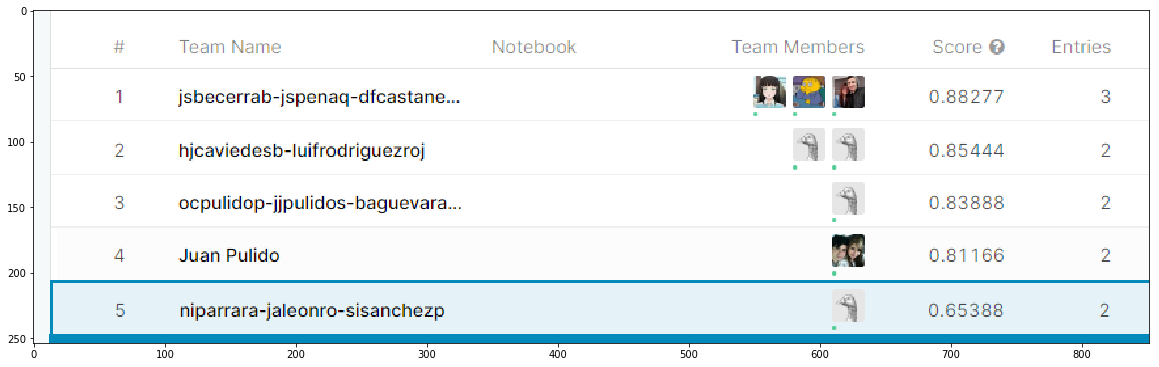

In [58]:
from PIL import Image
from matplotlib.pyplot import imshow
image = Image.open('final_score.png')
np.asarray(image)
plt.figure(figsize = (20,20))
plt.imshow(np.asarray(image))